## Semantic Cut-Paste Data Augmentation for Crop and Weed Classification 
This notebook implements a custom data augmentation pipeline tailored for agricultural image analysis, specifically targeting crop and weed segmentation.

The approach uses **SAM (Segment Anything Model)** to extract object masks from annotated field images (where green = crop, red = weed). These objects are then semantically classified, extracted, and randomly repositioned within the same image patch to simulate variation in plant distribution.

During this process, additional steps such as preprocessing, mask filtering, region validation, and augmentation of the ground truth are performed. The pipeline concludes with hybrid inpainting and smoothing to ensure visual consistency in the augmented images

*Library Imports*

Import all necessary libraries for image processing, segmentation, visualization, and SAM model usage.

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import label
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

*Load Input Image and Ground Truth*

Read the input image and its corresponding ground truth mask from file. Convert the images from BGR to RGB for proper display, and visualize both to verify the input.

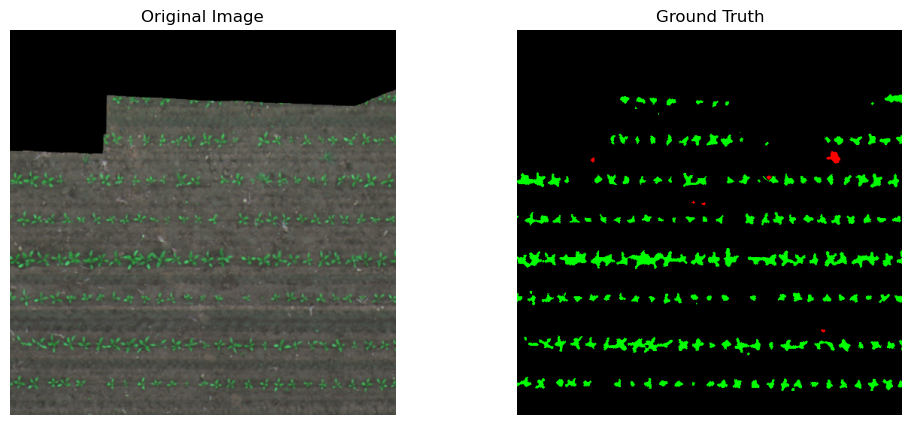

In [31]:
image_path = '8.png'
ground_truth_path = '8 gt.png'

image = cv2.imread(image_path)
ground_truth = cv2.imread(ground_truth_path)

# Convert BGR to RGB for display
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')
plt.axis('off')
plt.show()

*Generate Crop and Weed Masks from Ground Truth*

Define color thresholds to identify crops (green) and weeds (red) based on the ground truth image, which uses color coding for class labels.  
Binary masks for each class are generated using `cv2.inRange`, followed by morphological closing to clean up small gaps or noise in the mask.  
Finally, all masks and the original ground truth are displayed for visual inspection.

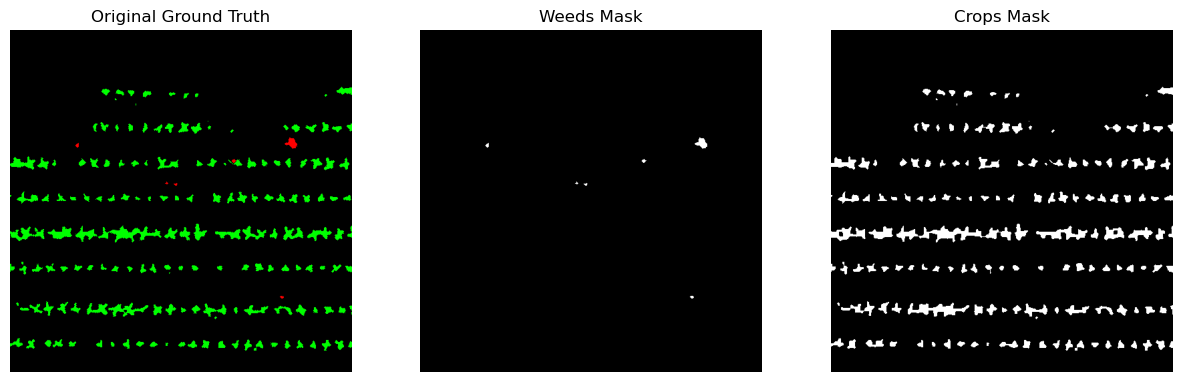

In [32]:
# Define the color ranges for weed and crop. 
# These values are in BGR format since OpenCV uses BGR by default.
lower_red = np.array([128, 0, 0])
upper_red = np.array([255, 0, 0])
lower_green = np.array([0, 128, 0])
upper_green = np.array([0, 255, 0])

# Create masks for weed and crop
mask_weed = cv2.inRange(ground_truth, lower_red, upper_red)
mask_crop = cv2.inRange(ground_truth, lower_green, upper_green)
# Invert the masks to get the actual weed and crop areas
kernel = np.ones((5, 5), np.uint8)
mask_weed = cv2.morphologyEx(mask_weed, cv2.MORPH_CLOSE, kernel)
mask_crop = cv2.morphologyEx(mask_crop, cv2.MORPH_CLOSE, kernel)

# Display the original image and the masks
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(ground_truth)
plt.axis('off')
plt.title('Original Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(mask_weed, cmap='gray')
plt.axis('off')
plt.title('Weeds Mask')

plt.subplot(1, 3, 3)
plt.imshow(mask_crop, cmap='gray')
plt.axis('off')
plt.title('Crops Mask')

plt.show()

*Object Segmentation with SAM (Segment Anything Model)*

Load the pretrained Segment Anything Model (SAM) and use it to automatically generate segmentation masks for both the input image and its corresponding ground truth.  
This step allows identifying distinct objects in the scene without relying on pre-defined classes or manual annotations.

The resulting masks are visualized by overlaying contours on the original and ground truth images, which helps to inspect how well SAM segments individual plant instances.

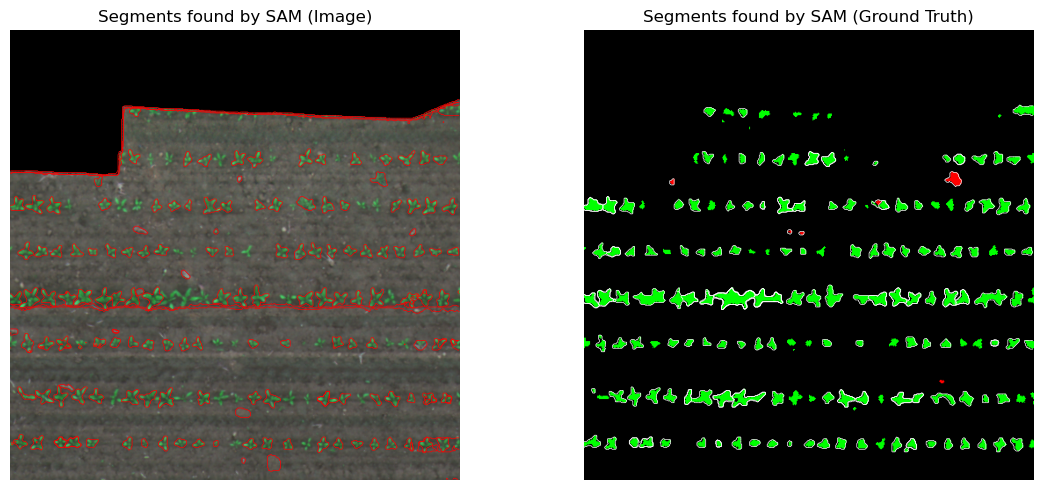

In [33]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)

# Generating masks for the image and ground truth
image_masks = mask_generator.generate(image)
gt_masks = mask_generator.generate(ground_truth)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(image)
for mask_data in image_masks:
    seg = mask_data['segmentation']
    axes[0].contour(seg, colors='red', linewidths=0.5)
axes[0].set_title('Segments found by SAM (Image)')
axes[0].axis('off')

axes[1].imshow(ground_truth)
for mask_data in gt_masks:
    seg = mask_data['segmentation']
    axes[1].contour(seg, colors='white', linewidths=0.5)
axes[1].set_title('Segments found by SAM (Ground Truth)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

As shown in the visual comparison above, SAM performs segmentation more accurately on the ground truth image, likely due to the clean black background and clear color-coded annotations. For this reason, we will use the **segments extracted from the ground truth** for the following steps, as they provide more precise object boundaries and less noisy masks.

*Visualize and Filter SAM-Generated Masks*

All segmentation masks generated by SAM from the ground truth image are visualized individually for inspection.

To remove noisy or irrelevant masks (e.g., large background regions), we compute the ratio of white pixels in each mask.  
Masks exceeding a specified threshold (`white_pixel_threshold = 0.5`) are discarded, while the remaining ones are merged into a single binary mask representing valid object candidates.

This filtering step helps exclude oversized or meaningless segments, improving the quality of the subsequent object extraction.

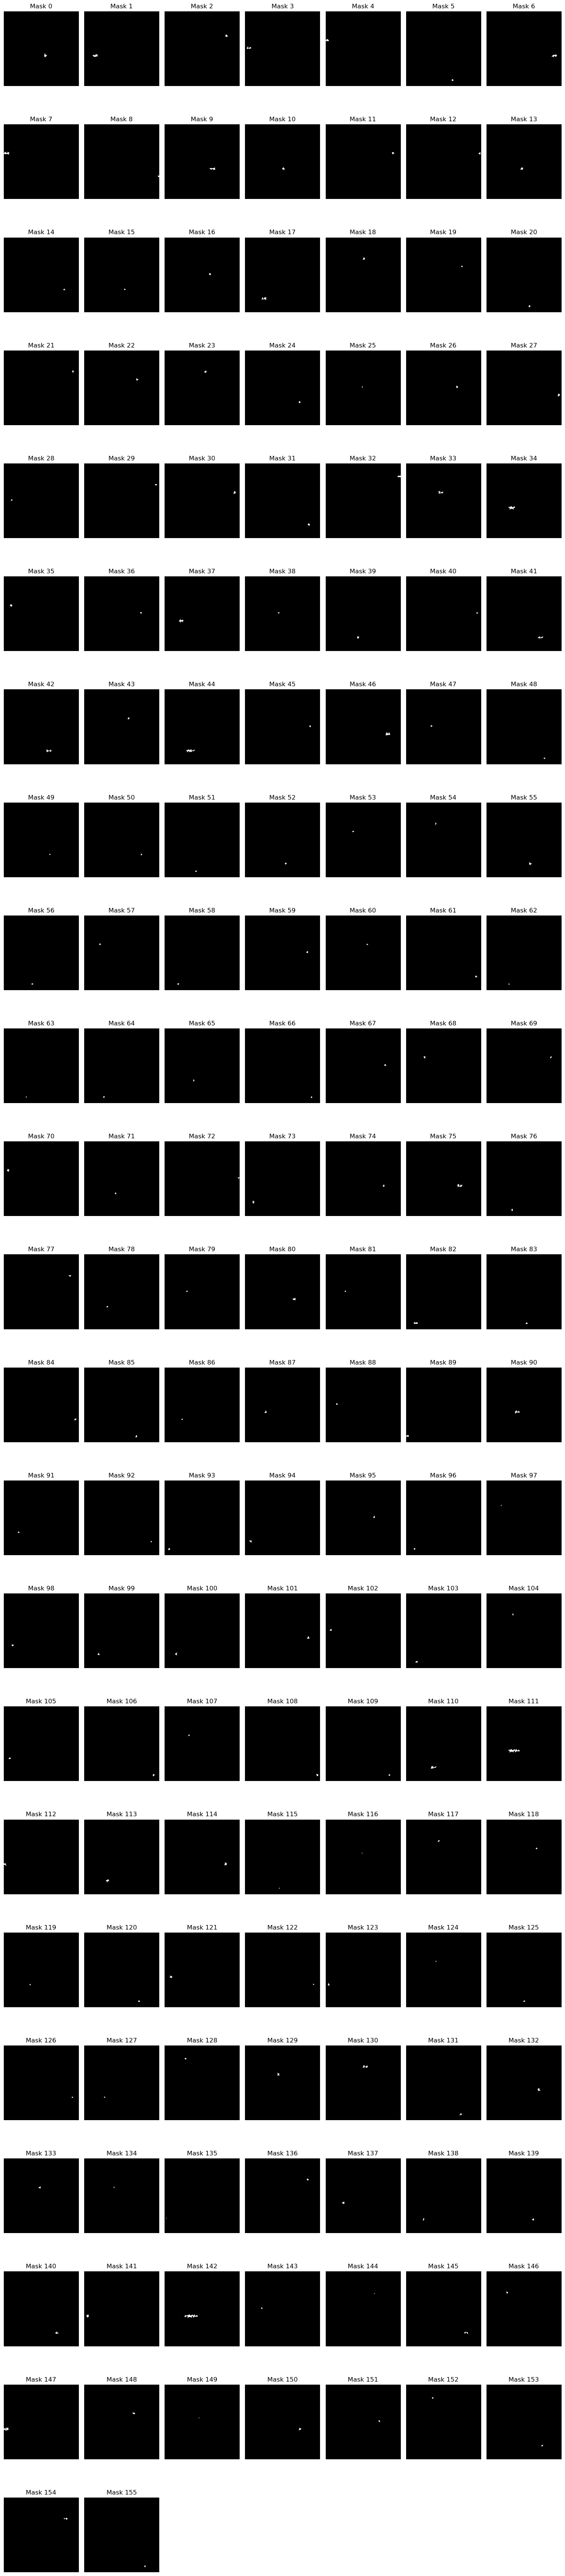

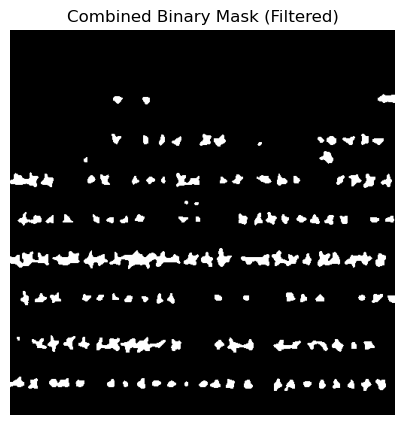

In [34]:
n_cols = 7
n_rows = (len(gt_masks) // n_cols) + 1
plt.figure(figsize=(15, n_rows * 3))

for idx, mask_data in enumerate(gt_masks):
    mask = mask_data['segmentation']
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask {idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# If a mask is too large, it might be a background or noise
# We can filter out masks based on their white pixel ratio
white_pixel_threshold = 0.5

height, width = ground_truth.shape[:2]
# Initialize a binary mask to combine all masks
binary_mask = np.zeros((height, width), dtype=np.uint8)

for idx, mask_data in enumerate(gt_masks):
    mask = mask_data['segmentation']
    
    # Compute the ratio of white pixels in the mask
    white_pixels = np.sum(mask)
    total_pixels = mask.size
    ratio_white = white_pixels / total_pixels
    
    # Filter the mask based on the white pixel ratio
    if ratio_white < white_pixel_threshold:
        binary_mask = np.logical_or(binary_mask, mask)
    else:
        # If the mask is too large, we discard it
        plt.figure(figsize=(5, 5))
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask {idx + 1} discarded - {ratio_white * 100:.2f}% white pixels')
        plt.axis('off')
        plt.show()

# Convert the binary mask to uint8 for display
binary_mask = (binary_mask * 255).astype(np.uint8)

plt.figure(figsize=(5, 5))
plt.imshow(binary_mask, cmap='gray')
plt.title('Combined Binary Mask (Filtered)')
plt.axis('off')
plt.show()

*Object Extraction and Semantic Classification*

From the filtered SAM masks, we extract individual objects by computing their bounding boxes.  
Each object is then classified as either **weed** or **crop** based on the color information in the corresponding region of the ground truth.

For each valid object:
- The corresponding image patch is extracted from the original RGB image.
- A binary mask is used to define the object's shape.
- An **RGBA image** is created, where the alpha channel preserves the object’s shape for seamless copy-paste operations.

These extracted objects are stored along with their type and original position, and will later be reused for semantic augmentation.

In [35]:
objects = []
for mask_data in gt_masks:
    mask = mask_data['segmentation']
    # Filter out small masks
    if np.sum(mask) < 100:  
        continue
        
    # Get the bounding box of the mask
    y, x = np.where(mask)
    y_min, y_max = y.min(), y.max()
    x_min, x_max = x.min(), x.max()
    
    # gt_patch is the patch of the ground truth image corresponding to bounding box of the object
    gt_patch = ground_truth[y_min:y_max+1, x_min:x_max+1]
    # Classification:
    # - Weed: Red channel > 128 (Channel B in BGR > 128)
    # - Crop: Green channel > 128 (Channel G in BGR > 128)
    is_weed = (gt_patch[:,:,0] > 128).any()
    is_crop = (gt_patch[:,:,1] > 128).any()
    
    if is_weed:
        obj_type = 'weed'
    elif is_crop:
        obj_type = 'crop'
    else:
        continue
    
    # Extract the object with transparence mask (alpha channel)
    # obj_img is the image RGB patch corresponding to the bounding box of the object
    obj_img = image[y_min:y_max+1, x_min:x_max+1].copy()
    # obj_mask is the binary mask of the object
    obj_mask = mask[y_min:y_max+1, x_min:x_max+1]
    
    # Generate an RGBA image (A=alpha channel for transparency)
    rgba = cv2.cvtColor(obj_img, cv2.COLOR_RGB2RGBA)
    # Set the alpha channel to 0 (transparent) for the background and 255 (opaque) for the object
    rgba[:,:,3] = obj_mask.astype(np.uint8) * 255
    
    objects.append({
        'image': rgba,
        'mask': obj_mask,
        'type': obj_type,
        'orig_pos': (x_min, y_min, x_max, y_max)
    })

*Identify Valid Regions for Object Placement*

To avoid placing objects over black or occupied areas, we first detect the **black regions** in the original image and create a binary mask.  
We also generate a **background mask** and define an **occupancy map** to track used areas during augmentation.

By combining these masks, we isolate regions that are:
- Not black
- Not already occupied
- Larger than a minimum region size (to avoid placing objects in tiny or noisy areas)

These valid regions are stored with their bounding boxes and will be used as potential targets for relocating extracted objects.

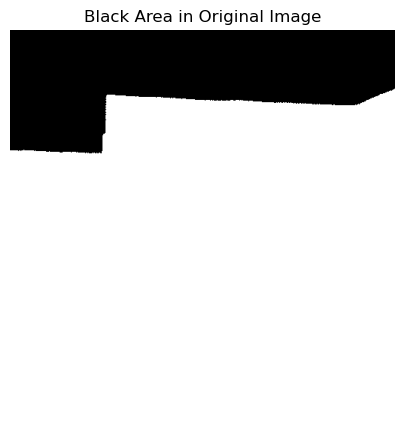

In [36]:
# Select the black area in the original image
black_area = cv2.inRange(image, (0, 0, 0), (0, 0, 0))
# Convert to uint8 and invert the mask for display
black_area = (black_area > 0).astype(np.uint8) * 255
inverted_black_area = cv2.bitwise_not(black_area)  
plt.figure(figsize=(5, 5))
plt.imshow(inverted_black_area, cmap='gray')
plt.title('Black Area in Original Image')
plt.axis('off')
plt.show()

# Create a mask for the background and the occupancy mask
background_mask = cv2.inRange(image, (0, 0, 0), (255, 255, 255))
occupancy_mask = np.zeros_like(background_mask)
min_region_size = 500 

# Combine the background mask with the black area to find valid regions
valid_areas = background_mask & (black_area == 0)
labeled, num_features = label(valid_areas)
valid_regions = []

for i in range(1, num_features+1):
    region_mask = (labeled == i)
    if np.sum(region_mask) > min_region_size:
        y, x = np.where(region_mask)
        valid_regions.append({
            'mask': region_mask,
            'bbox': (x.min(), y.min(), x.max(), y.max())
        })

*Augmentation*

A subset of the extracted objects (controlled by `perc_changes`) is randomly selected and relocated to new valid regions of the image.  
Each new position is checked to ensure:
- It does not overlap with the black area
- It is not already occupied
- It is large enough to fit the object

For each successful relocation:
- The object is removed from its original location in both the image and the ground truth
- It is pasted into the new position using the alpha channel for blending
- The ground truth is updated with the correct class color (red for weeds, green for crops)

The final augmented image and its updated ground truth are visualized side-by-side with the originals, and both are saved for later use.

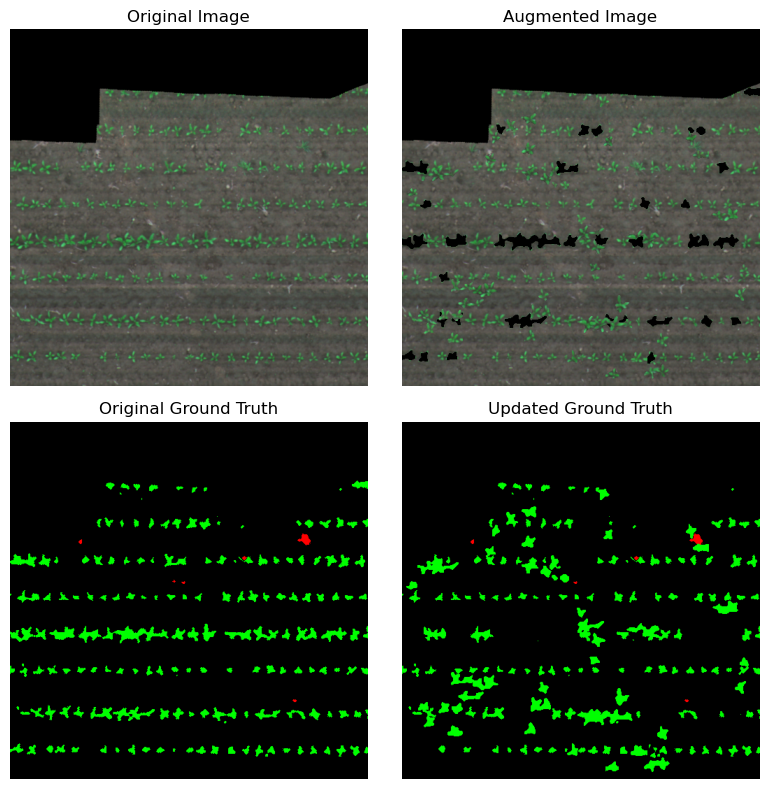

In [37]:
# perc_changes is the percentage of objects to be moved
perc_changes = 0.4
aug_image = image.copy()
aug_gt = ground_truth.copy()

for obj in objects:
    if random.random() > perc_changes:
        continue
    # Get the object's bounding box and mask
    h_object, w_object = obj['image'].shape[:2]
    obj_mask = obj['mask']
    # Get the object's original position
    xo, yo, _, _ = obj['orig_pos']
    
    # Find a new position for the object
    for region in random.sample(valid_regions, len(valid_regions)):
        x_min, y_min, x_max, y_max = region['bbox']
        if (y_max - y_min) < h_object or (x_max - x_min) < w_object:
            continue
        
        for _ in range(10):
            new_x = random.randint(x_min, x_max - w_object)
            new_y = random.randint(y_min, y_max - h_object)
            
            # The new position must not overlap with the black area
            if black_area[new_y:new_y+h_object, new_x:new_x+w_object].any():
                continue 
                
            if not occupancy_mask[new_y:new_y+h_object, new_x:new_x+w_object].any():
                aug_image[yo:yo+h_object, xo:xo+w_object][obj['mask']] = 0
                aug_gt[yo:yo+h_object, xo:xo+w_object][obj['mask']] = 0
                
                # Place the object in the new position
                obj_area = aug_image[new_y:new_y+h_object, new_x:new_x+w_object]
                alpha = obj['image'][:,:,3:] / 255.0
                obj_area[:] = obj_area * (1 - alpha) + obj['image'][:,:,:3] * alpha
                
                color = [255, 0, 0] if obj['type'] == 'weed' else [0, 255, 0]
                aug_gt[new_y:new_y+h_object, new_x:new_x+w_object][obj['mask']] = color
                
                occupancy_mask[new_y:new_y+h_object, new_x:new_x+w_object] = obj['mask']
                break

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(aug_image)
plt.title('Augmented Image')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(ground_truth)
plt.title('Original Ground Truth')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(aug_gt)
plt.title('Updated Ground Truth')
plt.axis('off')
plt.tight_layout()
plt.show()

cv2.imwrite('augmented_image_8.png', cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
cv2.imwrite('augmented_ground_truth_8.png', cv2.cvtColor(aug_gt, cv2.COLOR_RGB2BGR));


*Hybrid Inpainting and Edge Smoothing*

After object relocation, some empty regions may remain in the image where objects were removed.  
These areas (excluding the original black background) are detected and selectively filled using a hybrid strategy:

1. **Inpainting** is applied only to the empty areas introduced by the augmentation process, using OpenCV's TELEA algorithm.
2. **Edge-aware smoothing** is performed by identifying the borders of these regions and applying a Gaussian blur selectively, to better blend them with the surrounding pixels.
3. The original black areas of the patch are preserved without modification.

This post-processing step improves the visual quality of the augmented images, minimizing hard edges or artifacts introduced by object removal.

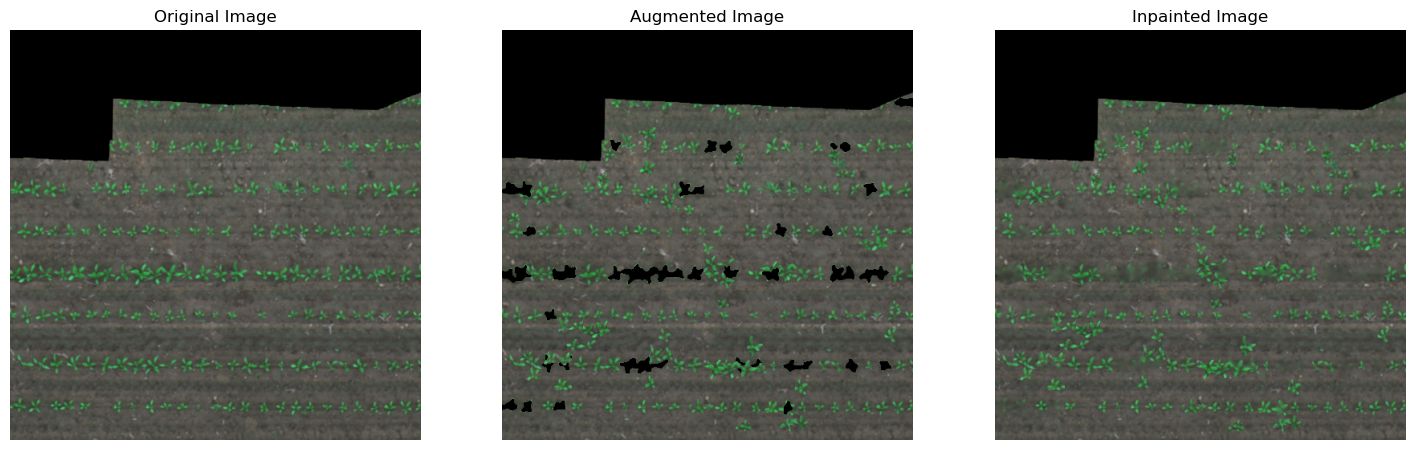

In [38]:
# Find the empty areas in the image that are not part of the black area and that must be filled 
# These areas are the ones that were moved
empty_areas = (aug_image.sum(axis=2) == 0) & (black_area == 0)
empty_areas = empty_areas.astype(np.uint8)

# Hybrid filling:
# 1. Black area remains unchanged
# 2. Inpainting only the empty areas created by the object movements
# 3. Smoothing only on the borders of the empty areas
if np.sum(empty_areas) != 0:
    # Inpainting with OpenCV
    img_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
    inpainted_bgr = cv2.inpaint(
        img_bgr, 
        empty_areas, 
        inpaintRadius=3,  
        flags=cv2.INPAINT_TELEA 
    )
    inpainted = cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2RGB)

    # Apply smoothing only on the borders of the empty areas
    # 1. Find contours of the empty areas
    # 2. Draw the contours on a mask
    # 3. Apply Gaussian blur to the inpainted image
    contours, _ = cv2.findContours(empty_areas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask_borders = np.zeros_like(empty_areas)
    cv2.drawContours(mask_borders, contours, -1, 1, 2)
    blurred = cv2.GaussianBlur(inpainted, (5,5), 0)
    inpainted = np.where(mask_borders[...,None], blurred, inpainted)
    final_image = inpainted
else:
    final_image = aug_image

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(aug_image)
plt.title('Augmented Image')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(final_image)
plt.title('Inpainted Image')
plt.axis('off')
plt.show()

cv2.imwrite('inpainted_image_8.png', cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR));